# Assignment 3: Tunably Rugged Landscapes
In our assignment last week we got our first hillclimber up and running, while in class week started to talk about fitness landscapes to begin thinking about search spaces, and population-based evolutionary algorithms to start complexifying how we traverse these search spaces.  In this week's assignment, we'll start to put these two things together and begin toying around with the pandora's box of algorithmic experimentation.

In particular, we'll explore the idea of generating parameterized fitness functions to being to explore the relationship between the type of problem we're trying to solve, and what features our evolutionary algorithm should have to solve it.  

*Note*: I know this looks like a lot of coding!  While we are building valuable infastructure here, much of the solutions here are modifications on prior work (from eariler in this assignment or the last one), and can largely be copy-and-pasted here, or written once as a function to call again later.  Despite this, it's still always a good idea to start in on assignments early (even if just reading through all the questions to estimate how long it might take you to complete)

In [1]:
# imports
import numpy as np
import copy
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import scikits.bootstrap as bootstrap
import warnings
warnings.filterwarnings('ignore') # Danger, Will Robinson! (not a scalable hack, and may surpress other helpful warning other than for ill-conditioned bootstrapped CI distributions)

import scipy.stats # for finding statistical significance

### N-K Landscape
In general, you'll be more likely to have a problem provided to you, rather than have to design a fitness funciton by hand.  So in this week's assignment, I'll provide the full fitness-landscape-generating function for you.  The below function implements Kaffman's N-K Landscape.  While it's not entirely necessary for you to understand every implementaton detail below, the N-K landscape idea is chosen because it's a particularly interesting toy problem -- and more reading on it can be found via many online resources (e.g. Kauffman and Weinberger's *The NK model of rugged fitness landscapes and its application to maturation of the immune response* -- inlcuded in the assigment zip folder as it is firewalled online)

The main things to know about the NK model are that:  It is a model of a tunably rugged fitness landscape, that means we have parameters that can affect the shape and ruggedness of the fitness landscape produced by this model.  While there are many variations, here we follow the original (simplest) model that includes just two parameters: **N** defines the length of the binary bit string genome, while **K** defines the ruggedness of the landscape (in particular how the fitness of each allele depends on other loci (nearby genes) in the genotype. 

*Note*: This is fully implemented and no action is needed from you, besides running the code block.

In [2]:
class Landscape:
    """ N-K Fitness Landscape
    """

    
    def __init__(self, n=10, k=2):
        self.n = n # genome length
        self.k = k # number of other loci interacting with each gene
        self.gene_contribution_weight_matrix = np.random.rand(n,2**(k+1)) # for each gene, a lookup table for its fitness contribution, which depends on this gene's setting and also the setting of its interacting neighboring loci
        
    # find values of interacting loci
    def get_contributing_gene_values(self, genome, gene_num):     
        contributing_gene_values = ""
        for i in range(self.k+1): # for each interacing loci (including the location of this gene itself)
            contributing_gene_values += str(genome[(gene_num+i)%self.n]) # for simplicity we'll define the interacting genes as the ones immediately following the gene in question.  Get the values at each of these loci
        return contributing_gene_values # return the string containing the values of all loci which affect the fitness of this gene
    
    # find the value of a partiuclar genome
    def get_fitness(self, genome):
        gene_values = np.zeros(self.n) # the value of each gene in the genome
        for gene_num in range(len(genome)): # for each gene
            contributing_gene_values = self.get_contributing_gene_values(genome, gene_num) # get the values of the loci which affect it
            gene_values[gene_num] = self.gene_contribution_weight_matrix[gene_num,int(contributing_gene_values,2)] # use the values of the interacting loci (converted from a binary string to base-10 index) to find the lookup table entry for this combination of genome settings
        return np.mean(gene_values) # define the fitness of the full genome as the average of the contribution of its genes (and return it for use in the evolutionary algoirthm)

### Hillclimber
Based on the hillclimber function from you last assignment (and informed by the posted solution, if you wish), copy an slightly modify the hillclimber to use this fitnes function.  For sake of running multiple trials, also please modify the record keeping to reutrn the solutions after the completion of the algorithm rather than printing them out during evolution. 

*Hint:* In python, functions can be treated as objects (e.g. passed as an argument to another function)

In [3]:
def hillclimber(total_generations = 100, bit_string_length = 10, num_elements_to_mutate= 1, fitness_function=None):
    """ Basic hillclimber, copied from last assignment
        
        parameters: 
        total_generations: (int) number of total iterations for stopping condition
        bit_string_length: (int) length of bit string genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
                           
        returns:
        solution: (numpy array) best solution found
        solution_fitness: (float) fitness of returned solution
        solution_generation: (int) generaton at which most fit solution was first discovered
    """

    # the initialization proceedure
    parent = np.random.randint(2, size = bit_string_length) #some initial candidate solution
    parent_fitness = fitness_function(parent) # assign fitness based on fitness function given as argument

    # initialize record keeping
    solution = None # best genome so far
    solution_fitness = 0 # fitness of best genome so far
    solution_generation = 0 # time (generations) when solution was found
    
    for generation_num in range(total_generations): # repeat

        # the modification procedure
        child = copy.deepcopy(parent) # inheretence from parent to child solution
        element_to_mutate = np.random.randint(bit_string_length) # randomly select the location in the child bit string to mutate
        child[element_to_mutate] = (child[element_to_mutate] + 1) % 2 # flip the bit at the chosen location

        # the assessement procedure
        child_fitness = fitness_function(child) # assign fitness to child 

        # selection procedure
        if child_fitness > parent_fitness: # if child is better (positive mutation)
            parent = child                  # the child will become the parent in the next generation
            parent_fitness = child_fitness  # we update fitness values for new parent here for ease of record keeping as well
            
        # record keeping
        if parent_fitness > solution_fitness: # if the new parent is the best found so far
            solution = parent                 # update best solution records
            solution_fitness = parent_fitness
            solution_generation = generation_num
        
    return solution, solution_fitness, solution_generation

### Q1: Landscape Ruggedness's effect on Hillclimbing
In class we discussed the potential for the fitness landscape to greatly affect a given search algorithm.  Let't start by generating varyingly rugged landscapes, and investigating how this impacts the effectiveness of a standard hillclimber.  

For each value of `k = 0..14` and a genome legnth of `15` please generate 100 unique fitness landscapes, and record the fitness value and time to convergence (when the most fit solution was found) for the hillclimber algorithm above on that landscape.  Print out the mean results for each `k` as you go to keep track of progress.  This output may look something like this:

<img src="terminal_output.png" align="left"/>

In [4]:
# hyperparameters
n=15; max_k=15; repetitions = 100

# initialize array to record results over different settings of k and repeated trials
solutions_found = np.zeros((max_k,repetitions,n))
fitness_found = np.zeros((max_k,repetitions))
generation_found = np.zeros((max_k,repetitions))

# initilize output
print(' k  mean fitness  mean generation found')
print('--  ------------  ---------------------')

for k in range(0,max_k): # for many values of k
    for i in range(repetitions): # for many repeated (independent -- make sure your results differ each run!) trials
        landscape = Landscape(n=n, k=k) # generate a random fitness landscape with this level of ruggeddness
        solution, fitness, solution_generation = hillclimber(total_generations = 100, bit_string_length = n, num_elements_to_mutate = 1, fitness_function=landscape.get_fitness) # run a hillclimber
        
        # record outputs
        solutions_found[k,i,:] = solution
        fitness_found[k,i] = fitness
        generation_found[k,i] = solution_generation
        
    # print average results for all repitions of this k
    print('{k:2d} {fit:10.3f} {gen:16.3f}'.format(k=k, fit=np.mean(fitness_found[k]), gen=np.mean(generation_found[k]))) # output to observe progress
    

 k  mean fitness  mean generation found
--  ------------  --------------------
 0      0.663           39.910
 1      0.692           36.870
 2      0.707           40.310
 3      0.702           34.650
 4      0.695           33.070
 5      0.694           32.180
 6      0.691           27.340
 7      0.681           24.000
 8      0.680           23.600
 9      0.676           21.540
10      0.669           20.580
11      0.658           19.870
12      0.655           17.780
13      0.651           16.280
14      0.642           15.790


Let's also record this result in a nested dictionary to be able to recall it later (for comparison to other results).  There is an implementation given below, but you're welcome to use `pandas` if you're more comforatable with that library for data manipulation and visualization.

In [5]:
experiment_results = {}
experiment_results["hillclimber"] = {"solutions_found":solutions_found, "fitness_found":fitness_found, "generation_found":generation_found}

### Q2: Plotting Results
Please visualize the above terminal output in a figure (feel free to recycle code from previous assignments).  You'll be generating this same plot many time (and even comparing multiple runs on a single figure), so you may want to invest in implementing this as a function at some point during this assigment -- but that is not strictly necessary now, and fell free to ignore the code stub below.  

In particular, please plot the `Time to Convergence (Generations)` and `Fitness` values (as you vary `K`) as two separate figures, as a single figure with multiple y-axes is messy and confusing.  Please include 95% boostrapped confidence intervals over your 100 repitions for eack `K`.  Please also inlcude the title of each experiment as a legend (for now just `hillclimber` is sufficient for this baseline case, and titles will make more sense in follow up experimental conditions).

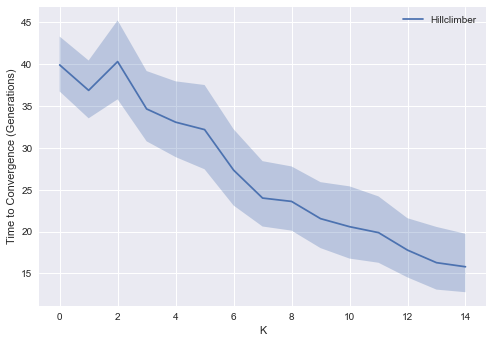

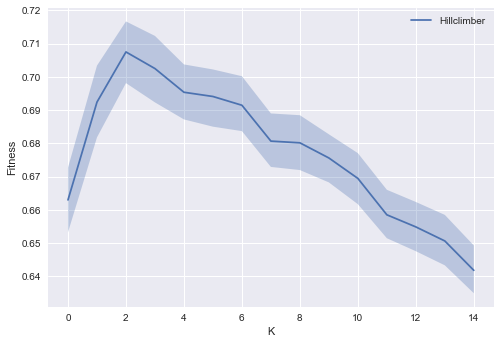

In [6]:
def plot_mean_and_bootstrapped_ci(input_data = None, name = "change me", x_label = "K", y_label="change me", y_limit = None):
    """
    
    parameters: 
    input_data: (numpy array of shape (max_k, num_repitions)) solution metric to plot
    name: (string) name for legend
    x_label: (string) x axis label
    y_label: (string) y axis label
    
    returns:
    None
    """
    
    fig, ax = plt.subplots() # generate figure and axes
    
    if isinstance(name, str): name = [name]; input_data = [input_data]
    
    for this_input_data, this_name in zip(input_data, name):
        max_k = this_input_data.shape[0]

        boostrap_ci_generation_found = np.zeros((2,max_k))
        for k in range(max_k):
            boostrap_ci_generation_found[:,k] = bootstrap.ci(this_input_data[k], np.mean, alpha=0.05)


        ax.plot(np.arange(max_k), np.mean(this_input_data,axis=1), label = this_name) # plot the fitness over time
        ax.fill_between(np.arange(max_k), boostrap_ci_generation_found[0,:], boostrap_ci_generation_found[1,:],alpha=0.3) # plot, and fill, the confidence interval for fitness over time
        ax.set_xlabel(x_label) # add axes labels
        ax.set_ylabel(y_label)
        if y_limit: ax.set_ylim(y_limit[0],y_limit[1])
        plt.legend(loc='best'); # add legend
    
plot_mean_and_bootstrapped_ci(input_data = generation_found, name = "Hillclimber", x_label = "K", y_label = "Time to Convergence (Generations)")

plot_mean_and_bootstrapped_ci(input_data = fitness_found, name = "Hillclimber", x_label = "K", y_label = "Fitness")

### Q3: Analysis of Hillclimber on Varying Ruggedness 
What do you notice about the trend line?  Is this what you expected?  Why or why not?

**It makes sense that in a more rugged lanscape, with a greater number of local optima, a hillclimber would converge faster -- not being able to escape a local optima once it found it.**

**It also makes sense that there is a general trend of fitness decreasing with increased ruggedness, as premature convergence to local optima increases.  I'm curiuos as to everyone's hypotheses around the decrease in fitness for very small K.  Perhaps it's the case that this is just the case of a fitness function which samples fewer random fitness values has less likilhood of producing any very high fitness peaks?  But if that were the case, one might expect higher variance in fitness at low values of K -- which doesn't appear to be the case.  I'm not totally sure what the root cause is.** 

### Q4: Random Restarts
One of the methods we talked about as a potential approach to escaping local optima in highly rugged fitness landscapes was to randomly restart search.  Using the same number of total generations (`100`), please implement a function which restarts search to a new random initialization every `20` generations (passing this value as an additoinal parameter to your hillclimber function).  Feel free to just copy and paste the hillclimber code block here to modify, for the sake of simplicity and easy gradability.  

In [7]:
def hillclimber(total_generations = 100, bit_string_length = 10, num_elements_to_mutate= 1, fitness_function=None, restart_every = None):
    """ Basic hillclimber, copied from last assignment
        
        parameters: 
        total_generations: (int) number of total iterations for stopping condition
        bit_string_length: (int) length of bit string genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        restart_every: (int) how frequently to randomly restart the hillclimber
                           
        returns:
        solution: (numpy array) best solution found
        solution_fitness: (float) fitness of returned solution
        solution_generation: (int) generaton at which most fit solution was first discovered
    """

    # the initialization proceedure
    parent = np.random.randint(2, size = bit_string_length) #some initial candidate solution
    parent_fitness = fitness_function(parent) # assign fitness based on fitness function given as argument

    # initialize record keeping
    solution = None # best genome so far
    solution_fitness = 0 # fitness of best genome so far
    solution_generation = 0 # time (generations) when solution was found
    
    for generation_num in range(total_generations): # repeat
        
        # random restart
        if restart_every and (generation_num+1)%restart_every == 0: # if turned on (value above 0) and time to rest (every x-number of generations)
            # the initialization proceedure
            parent = np.random.randint(2, size = bit_string_length) #some initial candidate solution
            parent_fitness = fitness_function(parent) # assign fitness based on fitness function given as argument

        # the modification procedure
        child = copy.deepcopy(parent) # inheretence from parent to child solution
        element_to_mutate = np.random.randint(bit_string_length) # randomly select the location in the child bit string to mutate
        child[element_to_mutate] = (child[element_to_mutate] + 1) % 2 # flip the bit at the chosen location

        # the assessement procedure
        child_fitness = fitness_function(child) # assign fitness to child 

        # selection procedure
        if child_fitness > parent_fitness: # if child is better (positive mutation)
            parent = child                  # the child will become the parent in the next generation
            parent_fitness = child_fitness  # we update fitness values for new parent here for ease of record keeping as well
            
        # record keeping
        if parent_fitness > solution_fitness: # if the new parent is the best found so far
            solution = parent                 # update best solution records
            solution_fitness = parent_fitness
            solution_generation = generation_num
        
    return solution, solution_fitness, solution_generation

### Q4b: Run Experiment
Slightly modify (feel free to copy and paste here) your experiment running code black above to analyze the effect of modifying `K` on `Time to Convergence (Generations)` and `Fitness`, again print progress and plotting results.  Please also save these results (and subsequent new ones) to your `experimental_results` dictionary for later use.

In [8]:
# hyperparameters
n=15; max_k=15; repetitions = 100

# initialize array to record results over different settings of k and repeated trials
solutions_found = np.zeros((max_k,repetitions,n))
fitness_found = np.zeros((max_k,repetitions))
generation_found = np.zeros((max_k,repetitions))

# initilize output
print(' k  mean fitness  mean generation found')
print('--  ------------  --------------------')

for k in range(0,max_k): # for many values of k
    for i in range(repetitions): # for many repeated (independent -- make sure your results differ each run!) trials
        landscape = Landscape(n=n, k=k) # generate a random fitness landscape with this level of ruggeddness
        solution, fitness, solution_generation = hillclimber(total_generations = 100, bit_string_length = n, num_elements_to_mutate = 1, fitness_function=landscape.get_fitness, restart_every=20) # run a hillclimber
        
        # record outputs
        solutions_found[k,i,:] = solution
        fitness_found[k,i] = fitness
        generation_found[k,i] = solution_generation
        
    # print average results for all repitions of this k
    print('{k:2d} {fit:10.3f} {gen:16.3f}'.format(k=k, fit=np.mean(fitness_found[k]), gen=np.mean(generation_found[k]))) # output to observe progress
    
experiment_results["restart every 20"] = {"solutions_found":solutions_found, "fitness_found":fitness_found, "generation_found":generation_found} # save results for later use

 k  mean fitness  mean generation found
--  ------------  --------------------
 0      0.657           61.600
 1      0.689           50.070
 2      0.700           51.870
 3      0.712           53.240
 4      0.712           54.520
 5      0.714           51.380
 6      0.701           54.550
 7      0.710           51.260
 8      0.703           53.290
 9      0.700           51.020
10      0.698           47.460
11      0.693           43.410
12      0.693           47.080
13      0.682           48.160
14      0.679           44.060


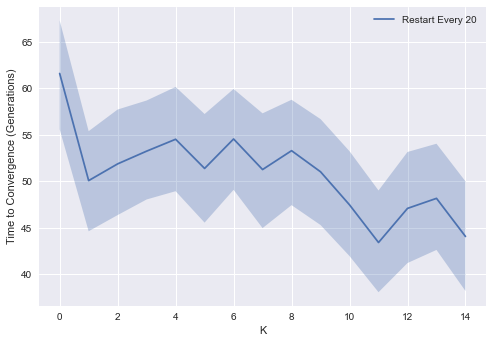

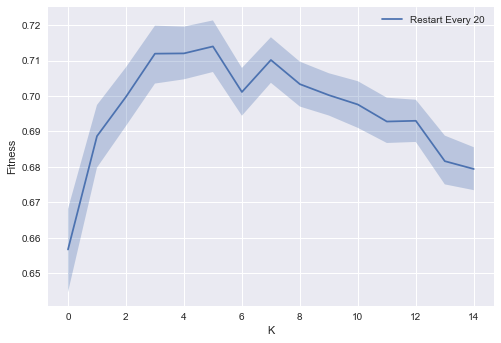

In [9]:
plot_mean_and_bootstrapped_ci(input_data = generation_found, name = "Restart Every 20", x_label = "K", y_label = "Time to Convergence (Generations)")

plot_mean_and_bootstrapped_ci(input_data = fitness_found, name = "Restart Every 20", x_label = "K", y_label = "Fitness")

### Q5: Analysis of Random Restarts
What trends do you see?  Is this what you were expecting?  How does this compare to the original hillclimber algorithm without random resets (please note any y-axis differences when comparing values/shapes of the curves)?

**I'm not surprised that the time to convergence increased, but am a bit surprised that it didn't increase more, or that the trend didn't reverse itself from before with more rugged landscapes showing late convergence times as the subsequent restarts find new peaks.  From an exploration-exploitation perspective, I guess it does make sense that with all peaks being of random (and independent) sizes, the likihood of finding a new better peak does drop over time (as fitness values from the previous best increase). I should also note here, that the way I implemented this is as a serial hillclimber, such that each random restart doesn't reset the time to find it -- whereas a parallel hillcimber that was exploring all solutions simultaneously as differnet trials, might have different implications for (wallclock or compute) time**

**I don't have a good intuition of the number of local optima (that could have been a question in this assignment -- but it takes a decent amount of compute to do exahustive search, necessary for knowing the total number of optima, on any reasonably sizes search landscape).  But I am somewhat surprised that there's still such a noticable drop off if fitness as ruggednes increases, as with 5-attempts to drop a new random starting point over our 100 generations, I would have imagined it reasonably likely to land on a good peak at some point.  It may also be the case that with such a high value of K, the fitness landscape becomes hierarchically rugged, in which case the value of each local optima would NOT be independedent and random, and may more peaks would need to be explored to find one of the highly fit ones.**

### Q6: Modifying mutation size
We've talked about a number of other potential modifications/complexifications to the original hillclimber aglorithm in class, so let's experiment with some of them here.  Here, please modying your above a hillclimber (again please just copy and paste the code block here) to mutate multiple loci when generating the child from a parent.

*Hint*: Be careful of the difference between modifying multiple genes and modifying the same gene multiple times

In [10]:
def hillclimber(total_generations = 100, bit_string_length = 10, num_elements_to_mutate= 1, fitness_function=None, restart_every = None):
    """ Basic hillclimber, copied from last assignment
        
        parameters: 
        total_generations: (int) number of total iterations for stopping condition
        bit_string_length: (int) length of bit string genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        restart_every: (int) how frequently to randomly restart the hillclimber
                           
        returns:
        solution: (numpy array) best solution found
        solution_fitness: (float) fitness of returned solution
        solution_generation: (int) generaton at which most fit solution was first discovered
    """

    # the initialization proceedure
    parent = np.random.randint(2, size = bit_string_length) #some initial candidate solution
    parent_fitness = fitness_function(parent) # assign fitness based on fitness function given as argument

    # initialize record keeping
    solution = None # best genome so far
    solution_fitness = 0 # fitness of best genome so far
    solution_generation = 0 # time (generations) when solution was found
    
    for generation_num in range(total_generations): # repeat
        
        # random restart
        if restart_every and (generation_num+1)%restart_every == 0: # if turned on (value above 0) and time to rest (every x-number of generations)
            # the initialization proceedure
            parent = np.random.randint(2, size = bit_string_length) #some initial candidate solution
            parent_fitness = fitness_function(parent) # assign fitness based on fitness function given as argument


       # the modification procedure
        child = copy.deepcopy(parent) # inheretence from parent to child solution
        
        elements_to_mutate = set() # using a set, rather than a list to keep track of the loci to mutate, as this will remove duplicate indexes, meaning each mutation will be to a different loci
        while len(elements_to_mutate)<num_elements_to_mutate: # while (instead of for) also acocunts for the potential of a randomly chosen loci not being a new index in the set
            elements_to_mutate.add(np.random.randint(bit_string_length)) # randomly select the location in the child bit string to mutate
        for this_element_to_mutate in elements_to_mutate:
            child[this_element_to_mutate] = (child[this_element_to_mutate] + 1) % 2 # flip the bit at the chosen location


        # the assessement procedure
        child_fitness = fitness_function(child) # assign fitness to child 

        # selection procedure
        if child_fitness > parent_fitness: # if child is better (positive mutation)
            parent = child                  # the child will become the parent in the next generation
            parent_fitness = child_fitness  # we update fitness values for new parent here for ease of record keeping as well
            
        # record keeping
        if parent_fitness > solution_fitness: # if the new parent is the best found so far
            solution = parent                 # update best solution records
            solution_fitness = parent_fitness
            solution_generation = generation_num
        
    return solution, solution_fitness, solution_generation

### Q6b: Expectations
In this experiment, let's set the number of elements to be mutated to `5` when generating a new child.

Before running the code, what do (did) you expect the result to be based on the results of the original hillclimber, the random restart condition, and the implications that a larger mutatoin rate may have?

**I expect the preformance to be worse -- I figure that the jumps in the fitness landscape with this high a mutation size would lead to a pseudo-random search**

### Q7: Run experiment
Run the experiment and visualize (similar to **Q4b**, and feel free to copy a paste here again) to analyze the effect of a larger mutation size on the realationship between `K` and `Time to Convergence (Generations)` / `Fitness`.

In [11]:
# hyperparameters
n=15; max_k=15; repetitions = 100

# initialize array to record results over different settings of k and repeated trials
solutions_found = np.zeros((max_k,repetitions,n))
fitness_found = np.zeros((max_k,repetitions))
generation_found = np.zeros((max_k,repetitions))

# initilize output
print(' k  mean fitness  mean generation found')
print('--  ------------  --------------------')

for k in range(0,max_k): # for many values of k
    for i in range(repetitions): # for many repeated (independent -- make sure your results differ each run!) trials
        landscape = Landscape(n=n, k=k) # generate a random fitness landscape with this level of ruggeddness
        solution, fitness, solution_generation = hillclimber(total_generations = 100, bit_string_length = n, num_elements_to_mutate = 5, fitness_function=landscape.get_fitness) # run a hillclimber
        
        # record outputs
        solutions_found[k,i,:] = solution
        fitness_found[k,i] = fitness
        generation_found[k,i] = solution_generation
        
    # print average results for all repitions of this k
    print('{k:2d} {fit:10.3f} {gen:16.3f}'.format(k=k, fit=np.mean(fitness_found[k]), gen=np.mean(generation_found[k]))) # output to observe progress
    
experiment_results["mutate 5"] = {"solutions_found":solutions_found, "fitness_found":fitness_found, "generation_found":generation_found}

 k  mean fitness  mean generation found
--  ------------  --------------------
 0      0.632           52.390
 1      0.676           46.280
 2      0.688           47.950
 3      0.690           55.360
 4      0.687           44.960
 5      0.691           50.640
 6      0.683           48.600
 7      0.680           47.250
 8      0.683           41.680
 9      0.685           47.120
10      0.683           49.850
11      0.682           50.150
12      0.686           51.770
13      0.687           49.900
14      0.678           45.910


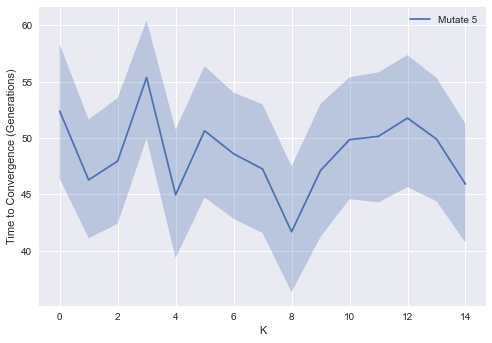

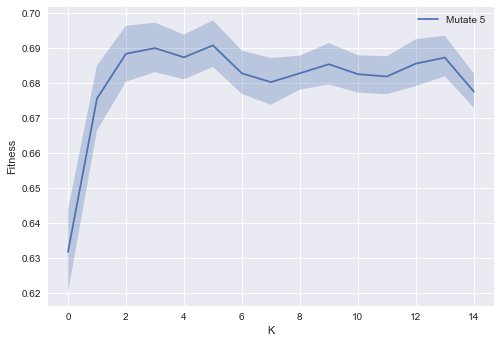

In [12]:
plot_mean_and_bootstrapped_ci(input_data = generation_found, name = "Mutate 5", x_label = "K", y_label = "Time to Convergence (Generations)")

plot_mean_and_bootstrapped_ci(input_data = fitness_found, name = "Mutate 5", x_label = "K", y_label = "Fitness")

### Q7b: Analysis
Is this what you expected/predicted?  If not, what is different and why might that be?

**In terms of fitness, it looks like the values are lower for small values of K, but higher for large values of K.  I didn't predict this, but in retrospect I could imagine extremely rugged landscapes were random search is the best solution (and didn't intuit these values of K to produce such a rugged landscpae, but evidentally that is the case).  It's also interesting that with this pseudo-random search, the ruggedness of the landscape (outside of the very small values of K) does not seem to affect the final fitness value much.**

### Q8: Accepting Negative Mutations
Another way we might be able to get out of local optima is by taking steps downhill away from that optima.  Add another arguement (`downhill_prob`) to your `hillclimber` function, which accepts a child with a negative mutataion with that given probability.

In [13]:
def hillclimber(total_generations = 100, bit_string_length = 10, num_elements_to_mutate= 1, fitness_function=None, restart_every = None, downhill_prob=0):
    """ Basic hillclimber, copied from last assignment
        
        parameters: 
        total_generations: (int) number of total iterations for stopping condition
        bit_string_length: (int) length of bit string genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        restart_every: (int) how frequently to randomly restart the hillclimber
        downhill_prob: (float) proportion of times when a downhill mutation is accepted
                           
        returns:
        solution: (numpy array) best solution found
        solution_fitness: (float) fitness of returned solution
        solution_generation: (int) generaton at which most fit solution was first discovered
    """

    # the initialization proceedure
    parent = np.random.randint(2, size = bit_string_length) #some initial candidate solution
    parent_fitness = fitness_function(parent) # assign fitness based on fitness function given as argument

    # initialize record keeping
    solution = None # best genome so far
    solution_fitness = 0 # fitness of best genome so far
    solution_generation = 0 # time (generations) when solution was found
    
    for generation_num in range(total_generations): # repeat
        
        if restart_every and (generation_num+1)%restart_every == 0:
            # the initialization proceedure
            parent = np.random.randint(2, size = bit_string_length) #some initial candidate solution
            parent_fitness = fitness_function(parent) # assign fitness based on fitness function given as argument

       # the modification procedure
        child = copy.deepcopy(parent) # inheretence from parent to child solution
        
        elements_to_mutate = set()
        while len(elements_to_mutate)<num_elements_to_mutate:
            elements_to_mutate.add(np.random.randint(bit_string_length)) # randomly select the location in the child bit string to mutate
        for this_element_to_mutate in elements_to_mutate:
            child[this_element_to_mutate] = (child[this_element_to_mutate] + 1) % 2 # flip the bit at the chosen location


        # the assessement procedure
        child_fitness = fitness_function(child) # assign fitness to child 

        # selection procedure
        if child_fitness > parent_fitness or np.random.rand() < downhill_prob: # if child is better (positive mutation)
            parent = child                  # the child will become the parent in the next generation
            parent_fitness = child_fitness  # we update fitness values for new parent here for ease of record keeping as well
            
        # record keeping
        if parent_fitness > solution_fitness: # if the new parent is the best found so far
            solution = parent                 # update best solution records
            solution_fitness = parent_fitness
            solution_generation = generation_num
        
    return solution, solution_fitness, solution_generation

### Q8b: Run the experiment
Same as above (run and plot), but now investigating the effect of a `downhill_prob` of `0.1` (10% chance) on relationship between ruggedness and performance

In [14]:
# hyperparameters
n=15; max_k=15; repetitions = 100

# initialize array to record results over different settings of k and repeated trials
solutions_found = np.zeros((max_k,repetitions,n))
fitness_found = np.zeros((max_k,repetitions))
generation_found = np.zeros((max_k,repetitions))

# initilize output
print(' k  mean fitness  mean generation found')
print('--  ------------  --------------------')

for k in range(0,max_k): # for many values of k
    for i in range(repetitions): # for many repeated (independent -- make sure your results differ each run!) trials
        landscape = Landscape(n=n, k=k) # generate a random fitness landscape with this level of ruggeddness
        solution, fitness, solution_generation = hillclimber(total_generations = 100, bit_string_length = n, num_elements_to_mutate = 1, fitness_function=landscape.get_fitness, restart_every=0, downhill_prob=0.1) # run a hillclimber
        
        # record outputs
        solutions_found[k,i,:] = solution
        fitness_found[k,i] = fitness
        generation_found[k,i] = solution_generation
        
    # print average results for all repitions of this k
    print('{k:2d} {fit:10.3f} {gen:16.3f}'.format(k=k, fit=np.mean(fitness_found[k]), gen=np.mean(generation_found[k]))) # output to observe progress
    
experiment_results["downhill probability 10"] = {"solutions_found":solutions_found, "fitness_found":fitness_found, "generation_found":generation_found}

 k  mean fitness  mean generation found
--  ------------  --------------------
 0      0.673           47.210
 1      0.700           52.370
 2      0.707           56.140
 3      0.724           57.990
 4      0.711           53.500
 5      0.711           51.530
 6      0.707           48.570
 7      0.707           53.620
 8      0.703           47.240
 9      0.700           50.360
10      0.695           47.520
11      0.687           44.550
12      0.681           47.960
13      0.677           45.550
14      0.674           45.660


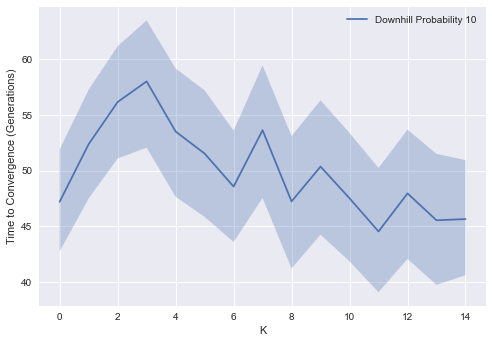

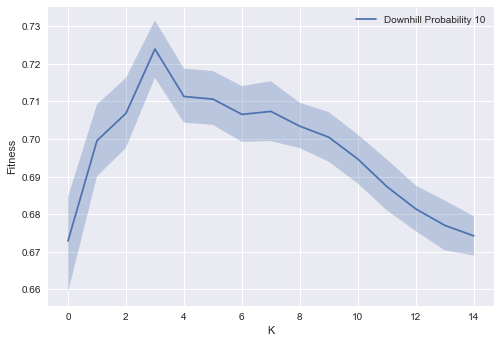

In [15]:
plot_mean_and_bootstrapped_ci(input_data = generation_found, name = "Downhill Probability 10", x_label = "K", y_label = "Time to Convergence (Generations)")

plot_mean_and_bootstrapped_ci(input_data = fitness_found, name = "Downhill Probability 10", x_label = "K", y_label = "Fitness")

### Q9: Visualizing Mulitple Runs
On the same plot (which may require modifying or reimplementing your plotting function, if you made one above), please plot the curves for all 4 of our experiments above on a single plot (including bootsrapped confidence intervals for all).  

*Hint*: Legends are especially important here!

*Hint*: It may be convenient to iterate over the dictionaries, turning them into lists before plotting (depending on your plotting script)

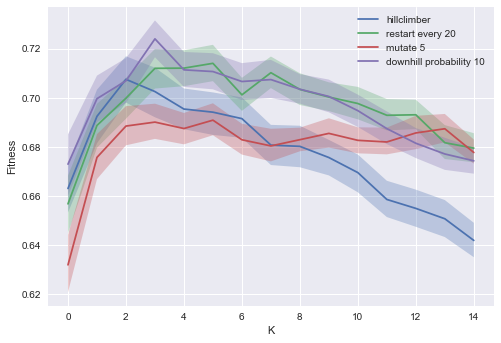

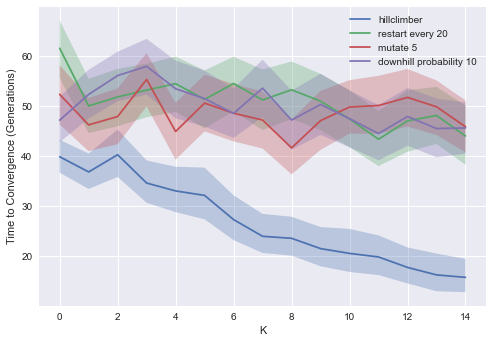

In [16]:
names_list = experiment_results.keys()
fitness_found_list = []
generation_found_list = []

for this_name in names_list:
    fitness_found_list.append(experiment_results[this_name]["fitness_found"])
    generation_found_list.append(experiment_results[this_name]["generation_found"])


plot_mean_and_bootstrapped_ci(input_data = fitness_found_list, name = names_list, x_label = "K", y_label = "Fitness")

plot_mean_and_bootstrapped_ci(input_data = generation_found_list, name = names_list, x_label = "K", y_label = "Time to Convergence (Generations)")

### Q9b: Analyzing Mulitple Runs
Do any new relationships or questions occur to you as you view these?

**I expected the solutions to escape local optima to outperform the naive hillclimber, but did not expect them to converge to such a similar value as K increases (for both fitness and time to convergence).  I wonder how universal this is, as the hyperparameter values I selected for each of these approaches were decided upon quite arbitrarily and without any intention of creating such a convergence.  It's nice to see that the flat (inelastic) scaling of fitness with ruggeddness shown in the very high mutation rate setting wasn't also true with the other approaches (they do drop in fitness as landscapes become more rugged -- as I might expect), but it's intersting to see that convergence rate is pretty flat with respect to ruggedness across these different approaches.**

### Q10: Statistical Significance
Using the [`ranksums` test for significance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ranksums.html), please compare the values for each algorithm at `K=14` using your saved `experiment_results`, reporting the p-value for each combination of the 4 experiments.  Please do this for both the resulting fitness values, and the generation for which that solution was found.  The output may look something like this:

<img src="terminal_output_2.png" align="left"/>

In [37]:
k = 14

for metric in ["fitness_found","generation_found"]:
    print (metric,"\n----------------")
    for i in range(len(names_list)):
        name_i = list(names_list)[i]
        data_i = experiment_results[name_i][metric][k]
        for j in range(i+1,len(names_list)):    
            name_j = list(names_list)[j]
            data_j = experiment_results[name_j][metric][k]
            
            _, p_val = scipy.stats.ranksums(data_i, data_j)
            print('{name_i:>23} ({mean_i:3.2f}) <-> {name_j:>23} ({mean_j:3.2f});  p-val={p_val:5.3f}'.format(name_i=name_i ,mean_i=np.mean(data_i), name_j=name_j, mean_j=np.mean(data_j), p_val=p_val))
    print ('')

fitness_found 
----------------
            hillclimber (0.64) <->        restart every 20 (0.68);  p-val=0.000
            hillclimber (0.64) <->                mutate 5 (0.68);  p-val=0.000
            hillclimber (0.64) <-> downhill probability 10 (0.67);  p-val=0.000
       restart every 20 (0.68) <->                mutate 5 (0.68);  p-val=0.874
       restart every 20 (0.68) <-> downhill probability 10 (0.67);  p-val=0.403
               mutate 5 (0.68) <-> downhill probability 10 (0.67);  p-val=0.509

generation_found 
----------------
            hillclimber (15.79) <->        restart every 20 (44.06);  p-val=0.000
            hillclimber (15.79) <->                mutate 5 (45.91);  p-val=0.000
            hillclimber (15.79) <-> downhill probability 10 (45.66);  p-val=0.000
       restart every 20 (44.06) <->                mutate 5 (45.91);  p-val=0.537
       restart every 20 (44.06) <-> downhill probability 10 (45.66);  p-val=0.569
               mutate 5 (45.91) <-> downhi

### Q11: Hyperparameter Search
Its cool to see the differences that these approaches have over the baseline hillcimber, but the values for each parameter that we've asked you to investigate are totally arbitrarily chosen.  For example, who's to say that doing random resets every `20` generations is ideal?  So let's find out!  

Please modify the code above for which you varied `K` to see the effect on `Fitness` and `Time to Convergence (Generations)`, to now keep a constant `K=14` and vary how frequently do you random resets within the fixed `100` generations of evolution.  Explore this relationship for values of resets ranging from never (`0`) up to every `29` generations.  

In [41]:
# hyperparameters
n=15; k=14; max_restart_every=30; repetitions = 100

# initialize array to record results over different settings of num_elements_to_mutate and repeated trials
solutions_found = np.zeros((max_restart_every,repetitions,n))
fitness_found = np.zeros((max_restart_every,repetitions))
generation_found = np.zeros((max_restart_every,repetitions))

# initilize output
print(' restart every  mean fitness  mean generation found')
print('--------------  ------------  --------------------')

for this_restart_every in range(0,max_restart_every): # for many values of k
    for i in range(repetitions): # for many repeated (independent -- make sure your results differ each run!) trials
        landscape = Landscape(n=n, k=k) # generate a random fitness landscape with this level of ruggeddness
        solution, fitness, solution_generation = hillclimber(total_generations = 100, bit_string_length = n, num_elements_to_mutate = 1, fitness_function=landscape.get_fitness, restart_every=this_restart_every) # run a hillclimber
        
        # record outputs
        solutions_found[this_restart_every,i,:] = solution
        fitness_found[this_restart_every,i] = fitness
        generation_found[this_restart_every,i] = solution_generation
        
    # print average results for all repitions of this k
    print('{this_restart_every:8d} {fit:15.3f} {gen:17.3f}'.format(this_restart_every=this_restart_every, fit=np.mean(fitness_found[this_restart_every]), gen=np.mean(generation_found[this_restart_every]))) # output to observe progress

 restart every  mean fitness  mean generation found
--------------  ------------  --------------------
       0           0.643            15.770
       1           0.699            51.570
       2           0.694            53.450
       3           0.690            45.570
       4           0.687            48.970
       5           0.683            50.230
       6           0.687            51.350
       7           0.685            50.950
       8           0.688            50.150
       9           0.685            47.620
      10           0.687            48.740
      11           0.686            48.690
      12           0.683            50.810
      13           0.685            45.760
      14           0.676            47.530
      15           0.680            52.940
      16           0.676            53.470
      17           0.682            47.420
      18           0.678            51.300
      19           0.681            45.270
      20           0.675            4

### Q11b: Visualization
Similar to before (with `K`), please plot `Fitness` and `Time to Convergence (Generations)` as a funciton of how frequently we apply random restarts (`Restart Every`)

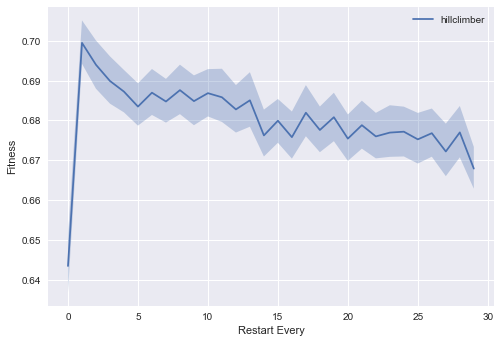

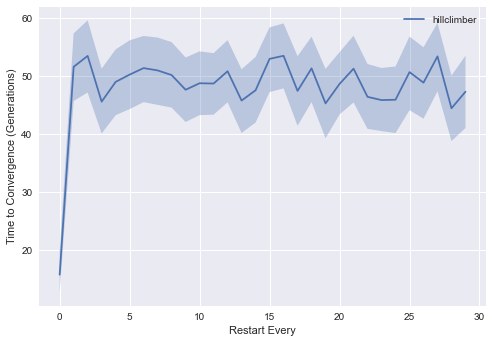

In [42]:
plot_mean_and_bootstrapped_ci(input_data = fitness_found, name = "hillclimber", x_label = "Restart Every", y_label = "Fitness")

plot_mean_and_bootstrapped_ci(input_data = generation_found, name = "hillclimber", x_label = "Restart Every", y_label = "Time to Convergence (Generations)")

### Q11c: The effect of ruggedness
The above plots are for a single value of `K`=14.  Repeat this same experiment below, just changing the value of `K` to `0`, to see what this experiment looksl like on a less-rugged landscape.

In [22]:
# hyperparameters
n=15; k=0; max_restart_every=30; repetitions = 100

# initialize array to record results over different settings of num_elements_to_mutate and repeated trials
solutions_found = np.zeros((max_restart_every,repetitions,n))
fitness_found = np.zeros((max_restart_every,repetitions))
generation_found = np.zeros((max_restart_every,repetitions))

# initilize output
print(' restart every  mean fitness  mean generation found')
print('--  ------------  --------------------')

for this_restart_every in range(0,max_restart_every): # for many values of k
    for i in range(repetitions): # for many repeated (independent -- make sure your results differ each run!) trials
        landscape = Landscape(n=n, k=k) # generate a random fitness landscape with this level of ruggeddness
        solution, fitness, solution_generation = hillclimber(total_generations = 100, bit_string_length = n, num_elements_to_mutate = 1, fitness_function=landscape.get_fitness, restart_every=this_restart_every) # run a hillclimber
        
        # record outputs
        solutions_found[this_restart_every,i,:] = solution
        fitness_found[this_restart_every,i] = fitness
        generation_found[this_restart_every,i] = solution_generation
        
    # print average results for all repitions of this k
    print('{this_restart_every:2d} {fit:10.3f} {gen:16.3f}'.format(this_restart_every=this_restart_every, fit=np.mean(fitness_found[this_restart_every]), gen=np.mean(generation_found[this_restart_every]))) # output to observe progress
    
# experiment_results["restart every 20"] = {"solutions_found":solutions_found, "fitness_found":fitness_found, "generation_found":generation_found}

 restart every  mean fitness  mean generation found
--  ------------  --------------------
 0      0.650           37.960
 1      0.621           52.770
 2      0.629           51.490
 3      0.627           52.330
 4      0.621           44.630
 5      0.640           51.640
 6      0.622           51.850
 7      0.640           51.980
 8      0.638           50.640
 9      0.634           53.160
10      0.641           51.380
11      0.645           45.710
12      0.638           52.600
13      0.649           48.800
14      0.655           51.710
15      0.645           53.180
16      0.661           50.630
17      0.654           50.900
18      0.650           48.850
19      0.656           52.340
20      0.662           55.080
21      0.665           50.540
22      0.665           51.870
23      0.664           49.230
24      0.671           51.250
25      0.661           52.620
26      0.662           50.160
27      0.657           44.840
28      0.666           48.940
29      0.

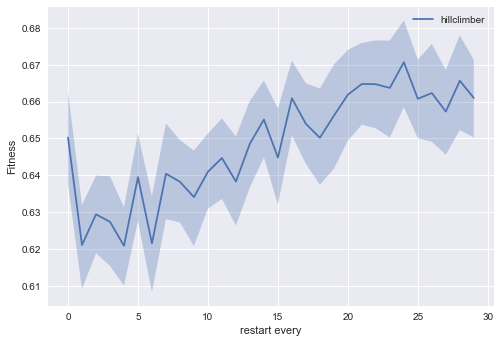

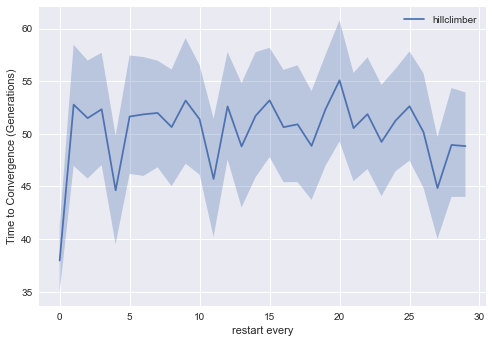

In [23]:
plot_mean_and_bootstrapped_ci(input_data = fitness_found, name = "hillclimber", x_label = "restart every", y_label = "Fitness")

plot_mean_and_bootstrapped_ci(input_data = generation_found, name = "hillclimber", x_label = "restart every", y_label = "Time to Convergence (Generations)")

### Q12: Analysis
What trends to you see from the figs for `K=14` vs. `K=0`?  Are you surprised by this?  What does it imply about the relationship between ruggedness and random restarts?  Does it make you want to try and other experiments (what would be the next thing you'd investigate)?

**Regarding fitness, in the more rugged landscape (K=14), it appears as though there are minimal effects, but a small drop in performance as the time between restarts increases (and the total number of restarts which can be fit in the 100 total generations drops).  In a highly rugged landscape where very little hillclimbing is possible, it makes sense that having more time between restarts to climb up peaks may not be as helpful as simply dropping more random starting points (i..e more closely approximating random search).**

**In the less rugged landscape (K=0), it appears as though increasing the time between restarts (decreasing the total number of restarts) is quite helpful, with increasing fitness as more time is allowed for hillclimbing between restarts.  Since we have a less rugged landscape here that should be more able to be more effectively climbed, it makes sense that allwoing more time to asccend each of the (fewer number of) peaks is helpful here.**  
**While there are many things that would be interest to explore with more time, some of the first that comes to mind might be the optimal value of any of the other hyperparameters (e.g. mutation size, or probability of accepting a downhill mutation).  I would also be interested in examing the interactive effects of multiple of these approaches (e.g. accepting downhill mutations with a large mutation size) -- both on the resulting fitness values and also on the optimal settings of each hyperparameter.  The Kauffman and Weinberger paper desciribing the NK model also provides an analysis of the exact number of local in a landscape based on its values of N and K (via exhausive search), and I might also be interested also looking at metrics that include the exact local optima (e.g. total number of local optima found, distance between optima found to determine global search space coverage of different mechanism) when comparing the approahes we look at here.**

### Congratulations, you made it to the end!
Wow that was a bit of a long one.  Hopefully you enjoyed the open-ended experimentation though

Please save this file as a .ipynb, and also download it as a .pdf, uploading **both** to blackboard to complete this assignment.  

For your submission, please make sure that you have renamed this file (and that the resulting pdf follows suit) to replce `[netid]` with your UVM netid.  This will greatly simplify our grading pipeline, and make sure that you receive credit for your work.  

#### Academic Integrity Attribution
During this assignment I collaborated with:

**Norm Macdonald**